In [1]:
# !pip install qiskit-aqua
# !pip install qiskit
# !pip install qiskit_optimization

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
import numpy as np
import pandas as pd
import time
import math
import itertools
import os

In [4]:
#from drive.MyDrive.Saarland.QAI import utils
#from drive.MyDrive.Saarland.QAI import min_cut_solvers

# import dimod
# from dwave.system.samplers import DWaveSampler
# from dwave.system.composites import EmbeddingComposite

In [5]:
import utils
import min_cut_solvers
# import Utils_Solvers

In [6]:
def evaluateSplits(coalition, coalition_values, **kwargs):
    #print("coalition",coalition,end='=')
    agents = coalition.split(',')
    n_agents = len(agents)
    best_cost_brute = f[coalition]
    xbest_brute = [coalition]
    for b in range(1, 2**(n_agents-1)):
        x = [int(term) for term in reversed(list(bin(b)[2:].zfill(n_agents)))]
        first_half = ','.join([agent for i,agent in enumerate(agents) if int(x[i])])
        second_half = ','.join([agent for i,agent in enumerate(agents) if not int(x[i])])
        if best_cost_brute <= (f[first_half]+f[second_half]):
            best_cost_brute = f[first_half]+f[second_half]
            xbest_brute = [first_half, second_half]
    #print(xbest_brute, best_cost_brute)
    return xbest_brute, best_cost_brute

In [7]:
def IDP(coalition_values, evaluateSplits = evaluateSplits, min_cut_solver = min_cut_solvers.min_cut_brute_force, **kwargs):
    n_agents = math.ceil(math.log(len(coalition_values),2))
    global t
    t = {}
    global f
    f = {}
    for coalition,coalition_value in coalition_values.items():
        t[coalition] = [coalition]
        f[coalition] = coalition_value
    for coalition_size in range(2, n_agents):
        #if((math.ceil((2*n_agents)/3)<coalition_size) and (coalition_size < n_agents)):                  # Ignoring this condition will make this function work as DP instead of IDP
        #  continue
        coalitions_of_cur_size = list(itertools.combinations(map(str,range(1,n_agents+1)), coalition_size))
        for curCoalition in coalitions_of_cur_size:
            curCoalition = ','.join(curCoalition)
            split_t, split_f = evaluateSplits(curCoalition, coalition_values, min_cut_solver = min_cut_solver, **kwargs)
            if split_f > f[curCoalition]:
                t[curCoalition] = split_t
                f[curCoalition] = split_f
    grand_coalition = ','.join(map(str,range(1,n_agents+1)))

    split_t, split_f = evaluateSplits(grand_coalition, coalition_values, min_cut_solver = min_cut_solver, **kwargs)
    if split_f > f[grand_coalition]:
        t[grand_coalition] = split_t
        f[grand_coalition] = split_f
    temp = t[grand_coalition].copy()
    optimal_cs = []
    while(len(temp)):
        C = temp.pop()
        if len(t[C])==1:
            optimal_cs+=t[C]
        if(len(t[C])!=1):
            temp += t[C]
    optimal_cs_value = sum([f[coalition] for coalition in optimal_cs])
    return optimal_cs, optimal_cs_value

#### IDP Top-down approach (for ISGs only)

In [8]:
def get_coalition_value(coalition, induced_subgraph_game):
    agents = coalition.split(',')
    return sum([induced_subgraph_game[','.join(map(str,sorted(map(int,key))))] for key in itertools.combinations(agents, 2)])

In [9]:
def evaluateSplits_min_cut(coalition, induced_subgraph_game, min_cut_solver = min_cut_solvers.min_cut_brute_force, **kwargs):
  #print("coalition",coalition,end='=')
    agents = coalition.split(',')
    n = len(agents)
    if n==1:
        return [coalition], 0
    if n==2:
        c_value = induced_subgraph_game[coalition]
        if c_value<=0:
            #print([agents[0],agents[1]], 0)
            return [agents[0],agents[1]], 0
        else:
            #print([coalition], c_value)
            return [coalition], c_value
    min_cut_mapping = {}
    for idx,agent in enumerate(agents):
        min_cut_mapping[agent] = str(idx+1)
    subproblem_as_induced_subgraph_game = {','.join([min_cut_mapping[vertex] for vertex in map(str,sorted(map(int,key)))]):induced_subgraph_game[','.join(map(str,sorted(map(int,key))))] for key in itertools.combinations(agents, 2)}
    xbest_brute, best_cost_brute = min_cut_solver(n,subproblem_as_induced_subgraph_game, **kwargs)
    if 0 in xbest_brute and 1 in xbest_brute:
        first_half = ','.join([agent for idx,agent in enumerate(agents) if xbest_brute[idx]])
        second_half = ','.join([agent for idx,agent in enumerate(agents) if not xbest_brute[idx]])
        bruteforce_solution_decoded = [first_half, second_half]
        best_cost_brute = get_coalition_value(first_half, induced_subgraph_game) + get_coalition_value(second_half, induced_subgraph_game)
    else:
        bruteforce_solution_decoded = [coalition]
        best_cost_brute = get_coalition_value(coalition, induced_subgraph_game)
    #print(bruteforce_solution_decoded, best_cost_brute)
    return bruteforce_solution_decoded, best_cost_brute

In [10]:
def IDP_min_cut_top_down(induced_subgraph_game, min_cut_solver = min_cut_solvers.min_cut_brute_force, **kwargs):
    grand_coalition = ','.join(map(str,sorted(map(int,(set([key.split(',')[i] for i in range(2) for key in induced_subgraph_game]))))))
    temp = [grand_coalition]
    optimal_cs = []
    while(len(temp)):
        c = temp.pop()
        c_split_t,c_split_f = evaluateSplits_min_cut(c, induced_subgraph_game, min_cut_solver = min_cut_solver, **kwargs)
        if len(c_split_t)==1:
            optimal_cs+=c_split_t
        if len(c_split_t)>1:
            temp += c_split_t
    return optimal_cs, sum([get_coalition_value(c, induced_subgraph_game) for c in optimal_cs])

### Data generation

In [11]:
def normal(size=1, mu=0, sigma=5, low=-10, high=10):
    values = np.random.normal(mu, sigma, size)
    #values = np.interp(values, (values.min(), values.max()), (low, high))
    return values

def uniform(size=1, low=-5, high=5):
    values = np.random.normal(low, high, size)
    #values = np.interp(values, (values.min(), values.max()), (low, high))
    return values

def laplace(size=1, loc=0, scale=5, low=-10, high=10):
    values = np.random.laplace(loc, scale, size)
    #values = np.interp(values, (values.min(), values.max()), (low, high))
    return values


def generate_induced_subgraph_game(distribution, n_agents, **kwargs):
    induced_subgraph_game = {}
    keys = list(itertools.combinations(range(1,n_agents+1), 2))
    totalinteractions = len(keys)
    values = distribution(totalinteractions, **kwargs)
    for i,key in enumerate(keys):
        induced_subgraph_game[','.join(map(str,key))] = round(values[i],2)
    return induced_subgraph_game

## Experiments

In [12]:
#@title Choose the solvers for experiments
IDP_brute_force = True#@param {type:"boolean"}
IDP_topdown_min_cut = True#@param {type:"boolean"}
IDP_topdown_qubo = False#@param {type:"boolean"}
IDP_min_cut_dwave_annealer = True#@param {type:"boolean"}


solver_flags = ''.join(map(str,map(int,[IDP_brute_force,IDP_topdown_min_cut,IDP_min_cut_dwave_annealer])))

#@markdown IDP implicitly means, it's using bottom-up approach.
#@markdown IDP_min_cut_qiskit_qaoa takes the longest time for execution.

In [13]:
#@markdown Keep it 'False' if using only top-down approach for large problem sizes.
convert_ISG_to_coalition_game = True#@param {type:"boolean"}

#@markdown Takes a long time for large problem instances as the number of coalition values will be of the order $O(2^n)$

In [14]:
#@markdown To generate a file compatible for runnning BOSS for the same problem instances used for the below experiments.
#@markdown Can be 'True' only if _convert_ISG_to_coalition_game_ is also 'True'
generate_file_for_BOSS = True#@param {type:"boolean"}

In [15]:
#report_save_location = '/content/drive/MyDrive/Saarland/QAI/DP-Q'

In [16]:
table_contents = []


distributions = [  
    # laplace, 
    uniform, 
    normal
]

 
n_agents = np.arange(2, 21).tolist()

seed = 123
QAOA_p_increment_flag = False # Useful for training QAOA. If true, checks by running QAOA for p>1 until the right solution is obtained.

report_filename = 'IDP_report_' + solver_flags + '_' +  str(seed) + '.txt'

problem_instances = {}

if generate_file_for_BOSS:
    file_obj = open(f"data_for_BOSS_{seed}.txt",'w')

for distribution in distributions:
    print(f'\nExecuting {distribution.__name__} distribution for n. agents: ',end=' ')
    problem_instances[distribution] = {}
    
    for n in n_agents:
        print(f'n. agents: {n}',end='\n')
        np.random.seed(seed=seed)
        induced_subgraph_game = utils.generate_induced_subgraph_game(distribution,n)

        # If only IDP top-down approach is being executed, need not generate the classical coalition game.
        if convert_ISG_to_coalition_game:
            coalition_game = utils.induced_subgraph_game_to_coalition_game(n, induced_subgraph_game)

        # For generating a file compatible for runnning BOSS for the same problem instanes used for the experiment here.
        if generate_file_for_BOSS:
            file_obj.write(distribution.__name__ + ' ' + str(n))
            for index, coalition in enumerate(coalition_game):
                binkey = bin(index + 1)[2:].zfill(n)
                temp = []
                for agent_index, agent in enumerate(binkey[::-1]):
                    if int(agent):
                        temp.append(agent_index + 1)
                file_obj.write(' ' + str(coalition_game[str(sorted(temp))[1:-1].replace(' ', '')]))
            file_obj.write('\n')

        problem_instances[distribution][n] = induced_subgraph_game

        start_time = time.time()
        if IDP_brute_force:
            bruteforce_solution, bruteforce_value = IDP(coalition_game)
        else:
            bruteforce_solution, bruteforce_value = None, None
        bruteforce_tte = (time.time() - start_time)
        print('--- total time bruteforce:', time.strftime('%H:%M:%S', time.gmtime(bruteforce_tte)), '\n')

        start_time = time.time()
        if IDP_topdown_min_cut:
            topdown_min_cut_solution, topdown_min_cut_value = IDP_min_cut_top_down(induced_subgraph_game)
            if bruteforce_value:
                try:
                    topdown_min_cut_quality = 1-(abs(topdown_min_cut_value-bruteforce_value)/bruteforce_value)
                except:
                    topdown_min_cut_quality = 1-(abs(topdown_min_cut_value-bruteforce_value))
            else:
                topdown_min_cut_quality = 1-(abs(topdown_min_cut_value-bruteforce_value))
        else:
            topdown_min_cut_solution, topdown_min_cut_value = None, None
            topdown_min_cut_quality = None
        topdown_min_cut_tte = (time.time() - start_time)
        print('--- BF min-cut top-down:', time.strftime('%H:%M:%S', time.gmtime(topdown_min_cut_tte)), '\n')

        start_time = time.time()
        if IDP_topdown_qubo:
            topdown_qubo_solution, topdown_qubo_value = IDP_min_cut_top_down(induced_subgraph_game, min_cut_solver = min_cut_solvers.min_cut_qiskit_classical_eigensolver)
            if bruteforce_value:
                try:
                    topdown_qubo_quality = 1-(abs(topdown_qubo_quality-bruteforce_value)/bruteforce_value)
                except:
                    topdown_qubo_quality =1-(abs(topdown_qubo_quality-bruteforce_value))
            else:
                topdown_qubo_quality = 1-(abs(topdown_qubo_value-bruteforce_value))
        else:
            topdown_qubo_solution, topdown_qubo_value = None, None
        topdown_qubo_tte = (time.time() - start_time)
        #print('--- total min-cut top-down:', time.strftime('%H:%M:%S', time.gmtime(topdown_qubo_tte)), '\n')
        
        
        start_time = time.time()
        #dwave_annealer_solution, dwave_annealer_value = np.array([0]*n),None #Call DWAVE ANNEALER SOLVER
        if IDP_min_cut_dwave_annealer:
            dwave_annealer_solution, dwave_annealer_value = IDP_min_cut_top_down(induced_subgraph_game, min_cut_solver = min_cut_solvers.min_cut_dwave_annealer)
            if IDP_topdown_min_cut:
                try:
                    dwave_annealer_quality = 1-(abs(dwave_annealer_value-bruteforce_value)/bruteforce_value)
                except:
                    dwave_annealer_quality =1-(abs(dwave_annealer_value-bruteforce_value))
            else:
                dwave_annealer_quality = 1-(abs(dwave_annealer_value-bruteforce_value))
        else:
            dwave_annealer_solution, dwave_annealer_value = None, None
            dwave_annealer_quality = None#((bruteforce_solution==dwave_annealer_solution).all() or (bruteforce_solution==(1-dwave_annealer_solution)).all())
        dwave_annealer_tte = (time.time() - start_time)
        print('--- total time QA:', time.strftime('%H:%M:%S', time.gmtime(dwave_annealer_tte)), '\n')

        row = []
        row.append(distribution.__name__)
        row.append(n)
        if IDP_brute_force:
            row.append(str(bruteforce_solution))
            row.append(bruteforce_value)
            row.append(bruteforce_tte)

        if IDP_topdown_min_cut:
            row.append(str(topdown_min_cut_solution))
            row.append(topdown_min_cut_value)
            row.append(topdown_min_cut_tte)
            row.append(topdown_min_cut_quality)

        if IDP_topdown_qubo:
            row.append(str(topdown_qubo_solution))
            row.append(topdown_qubo_value)
            row.append(topdown_qubo_tte)
            row.append(topdown_qubo_quality)

        if IDP_min_cut_dwave_annealer:
            row.append(str(dwave_annealer_solution))
            row.append(dwave_annealer_value)
            row.append(dwave_annealer_tte)
            row.append(dwave_annealer_quality)
        #report_file_obj = open(os.path.join(report_save_location,report_filename),'a+')
        report_file_obj = open(os.path.join(report_filename),'a+')
        report_file_obj.write('__'.join(map(str,row))+'\n')
        report_file_obj.close()
        table_contents.append(row)
    print('\n')
if generate_file_for_BOSS:
    file_obj.close()


Executing uniform distribution for n. agents:  n. agents: 2
--- total time bruteforce: 00:00:00 

--- BF min-cut top-down: 00:00:00 

--- total time QA: 00:00:00 

n. agents: 3
--- total time bruteforce: 00:00:00 

--- BF min-cut top-down: 00:00:00 

--- total time QA: 00:00:07 

n. agents: 4
--- total time bruteforce: 00:00:00 

--- BF min-cut top-down: 00:00:00 

--- total time QA: 00:00:10 

n. agents: 5
--- total time bruteforce: 00:00:00 

--- BF min-cut top-down: 00:00:00 

--- total time QA: 00:00:09 

n. agents: 6
--- total time bruteforce: 00:00:00 

--- BF min-cut top-down: 00:00:00 

--- total time QA: 00:00:14 

n. agents: 7
--- total time bruteforce: 00:00:00 

--- BF min-cut top-down: 00:00:00 

--- total time QA: 00:00:20 

n. agents: 8
--- total time bruteforce: 00:00:00 

--- BF min-cut top-down: 00:00:00 

--- total time QA: 00:00:25 

n. agents: 9
--- total time bruteforce: 00:00:00 

--- BF min-cut top-down: 00:00:00 

--- total time QA: 00:00:24 

n. agents: 10
--

## Display results from generated report file

In [17]:
report_filename = 'IDP_report_' + solver_flags + '_' +  str(seed) + '.txt'
report_filename

'IDP_report_111_123.txt'

In [18]:
IDP_brute_force = bool(int(report_filename.split('_')[-2][0]))
IDP_topdown_min_cut = bool(int(report_filename.split('_')[-2][1]))
IDP_min_cut_dwave_annealer = bool(int(report_filename.split('_')[-2][2]))

#report_file_obj = open(os.path.join(report_save_location,report_filename),'r')
report_file_obj = open(os.path.join(report_filename),'r')
table_contents = [line.replace('\n','').split('__') for line in report_file_obj.readlines()]

In [19]:
# table_contents = table_contents[156+38:]

In [20]:
def is_float(value):
  try:
    float(value)
    return True
  except:
    return False

for col_num, cell in enumerate(table_contents[0][2:]):
  if is_float(cell):
    for row in table_contents:
      row[col_num+2] = np.float(row[col_num+2])

In [21]:
#view output table
def highlight_false(s, column):
    is_false = pd.Series(data=False, index=s.index)
    is_false[column] = round(s.loc[column],2)<1.0
    return ['color: #ff8888' if is_false.any() else '' for v in is_false]

base_cols = ['Distribution', 'No. of Agents']
sub_cols = ['', '']

if IDP_brute_force:
    base_cols = base_cols+['Brute Force']*3
    sub_cols=sub_cols+['Result', 'Value', 'TTE']
if IDP_topdown_min_cut:
    base_cols = base_cols+['Top-down approach using min-cut']*4
    sub_cols=sub_cols+['Result', 'Value', 'TTE', 'Quality']
if IDP_topdown_qubo:
    base_cols = base_cols+['Top-down approach using qubo']*4
    sub_cols=sub_cols+['Result', 'Value', 'TTE', 'Quality']
if IDP_min_cut_dwave_annealer:
    base_cols = base_cols+['Dwave Annealer']*4
    sub_cols=sub_cols+['Result', 'Value', 'TTE', 'Quality']


column_arrays = [base_cols, sub_cols]


#df = pd.DataFrame(table_contents, columns=table_headers)
df = pd.DataFrame(table_contents, columns=pd.MultiIndex.from_arrays(column_arrays))


s = df.style.apply(highlight_false, column=('Top-down approach using min-cut', 'Quality'), axis=1)

cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', 'grey')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #1D1D1D; color: white;'
}
s.set_table_styles([cell_hover, index_names, headers])

result_col_bgcolor = '186A3B'
value_col_bgcolor = '784212'
tte_col_bgcolor = '154360'
correctness_col_bgcolor = '693f3f'

def get_nested_column_style(col_name, nested_col_name, border_color='black', bg_color = 'grey'):
    return {(col_name, nested_col_name):[{'selector': 'th', 'props': 'border-left: 1px solid '+border_color},
                                         {'selector': 'td', 'props': 'border-left: 1px solid '+ border_color+'; background-color: #'+bg_color}]}

def get_column_style(col_name, nested_col_names):
    result_dict = {}
    for nested_col_name, bg_color in nested_col_names:
        border_color = 'black'
        if nested_col_name is 'Result':
            border_color = 'white'
        temp = get_nested_column_style(col_name, nested_col_name, border_color, bg_color)
        result_dict[list(temp.keys())[0]]=list(temp.values())[0]
    return result_dict

d1 = {
    ('No. of Agents', ''): [{'selector': 'th', 'props': 'border-left: 1px solid white'},
                               {'selector': 'td', 'props': 'border-left: 1px solid white'}]}

if IDP_brute_force: d1.update(get_column_style('Brute Force',[('Result',result_col_bgcolor), ('Value',value_col_bgcolor), ('TTE',tte_col_bgcolor)]))
if IDP_topdown_min_cut: d1.update(get_column_style('Top-down approach using min-cut',[('Result',result_col_bgcolor), ('Value',value_col_bgcolor), ('TTE',tte_col_bgcolor), ('Correctness',correctness_col_bgcolor)]))
if IDP_topdown_qubo: d1.update(get_column_style('Top-down approach using qubo',[('Result',result_col_bgcolor), ('Value',value_col_bgcolor), ('TTE',tte_col_bgcolor), ('Correctness',correctness_col_bgcolor)]))
if IDP_min_cut_dwave_annealer: d1.update(get_column_style('Qiskit QAOA',[('Result',result_col_bgcolor), ('Value',value_col_bgcolor), ('TTE',tte_col_bgcolor), ('Correctness',correctness_col_bgcolor), ('reps (p)','1D1D1D')]))

s.set_table_styles(d1, overwrite=False, axis=0)

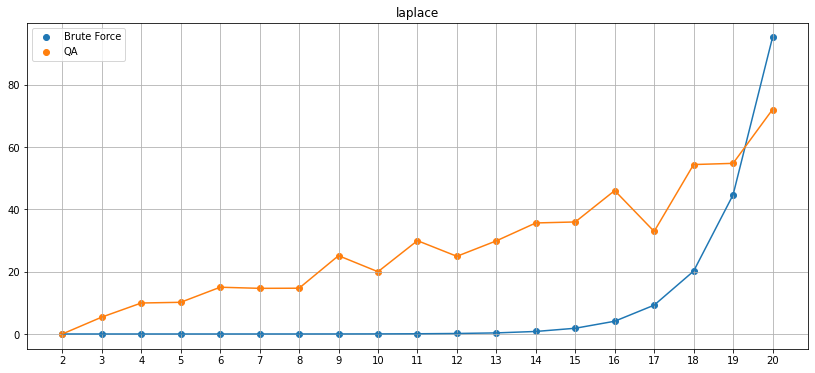

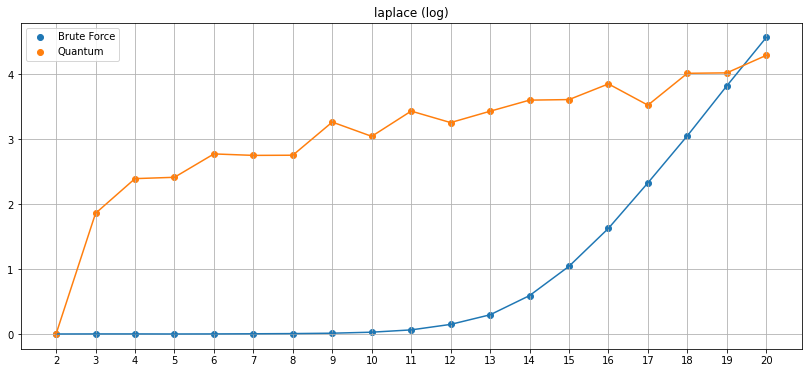

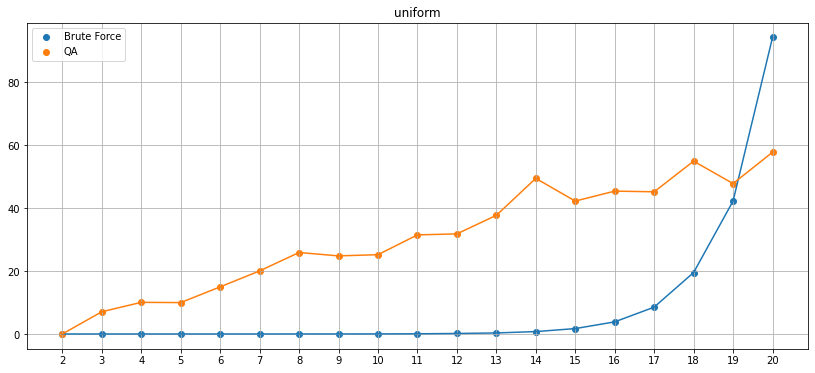

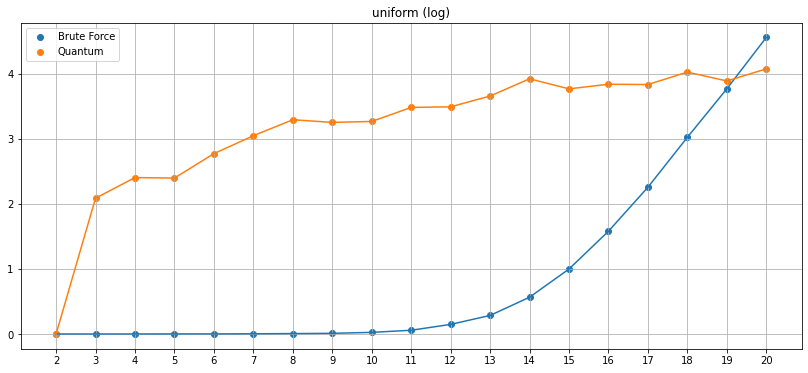

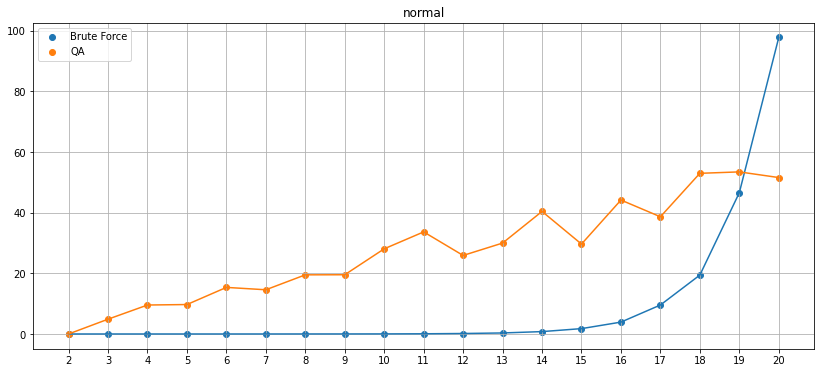

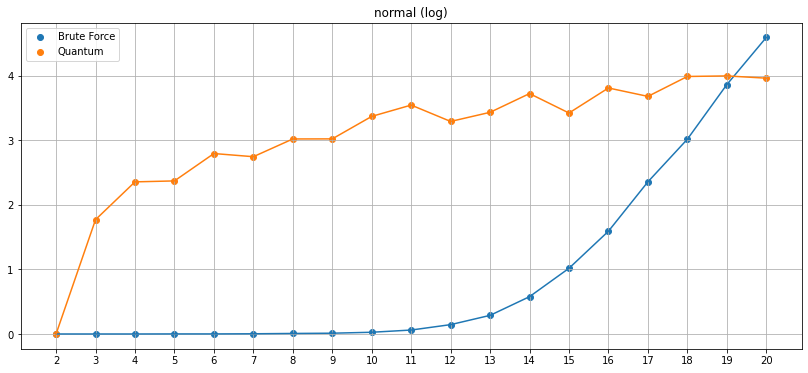

In [22]:
import matplotlib.pyplot as plt
for distr in df.Distribution.unique():
    data = df[df.Distribution == distr]
    
    
    plt.figure(figsize=(14,6))
    x = data['No. of Agents'].to_numpy()
    y_BF = data[('Top-down approach using min-cut', 'TTE')].astype(float).to_numpy()
    y_QA = data[('Dwave Annealer', 'TTE')].astype(float).to_numpy()
    
    plt.scatter(x, y_BF, label='Brute Force')
    plt.plot(x, y_BF)
    
    plt.scatter(x, y_QA, label='QA')
    plt.plot(x, y_QA)
    
    plt.grid()
    plt.title(distr)
    plt.legend()
    # plt.savefig(distr+'.png')
    plt.show()
    
    plt.figure(figsize=(14,6))

    log_BF = np.log(y_BF+1)
    log_QA = np.log(y_QA+1)
    
    plt.scatter(x, log_BF, label='Brute Force')
    plt.plot(x, log_BF)

    plt.scatter(x, log_QA, label='Quantum')
    plt.plot(x, log_QA)
    
    plt.grid()
    plt.title(distr + ' (log)')
    plt.legend()
    #plt.savefig(distr+'_log.png')
    plt.show()